In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.signal import find_peaks
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit, root_scalar

# =================== CONFIGURAÇÕES ===================
plt.style.use('default')
cmap = 'jet'
sigma_filter = 1.0  # Suavização do filtro Gaussiano 3D

# =================== LEITURA DOS DADOS ===================
arquivo = 'C:\\penelope\\KERNEL\\kernel resolucao 0.25\\3d-dose.dat'
Arq = np.loadtxt(arquivo)

i_max, j_max, k_max = map(int, np.max(Arq[:, 5:8], axis=0))
x_min, x_max = Arq[:, 0].min(), Arq[:, 0].max()
y_min, y_max = Arq[:, 1].min(), Arq[:, 1].max()
z_min, z_max = Arq[:, 2].min(), Arq[:, 2].max()

VoxelSize = [(x_max - x_min)/i_max, (y_max - y_min)/j_max, (z_max - z_min)/k_max]
EscalaX = np.linspace(x_min + VoxelSize[0]/2, x_max - VoxelSize[0]/2, i_max)
EscalaY = np.linspace(y_min + VoxelSize[1]/2, y_max - VoxelSize[1]/2, j_max)
EscalaZ = np.linspace(z_min + VoxelSize[2]/2, z_max - VoxelSize[2]/2, k_max)
# =================== MATRIZ DE DOSE ===================
Dose = np.zeros((i_max, j_max, k_max))
for linha in Arq:
    i, j, k = int(linha[5]) - 1, int(linha[6]) - 1, int(linha[7]) - 1
    Dose[i, j, k] = linha[3]

# =================== APLICA FILTRO GAUSSIANO 3D ===================
Dose_filt = gaussian_filter(Dose, sigma=sigma_filter)
max_dose_filtrada = np.max(Dose_filt)
# =================== FUNÇÃO SUPERGAUSSIANA ===================
def supergauss(x, A, mu, sigma, n):
    return A * np.exp(-((x - mu)**2 / (2 * sigma**2))**n)

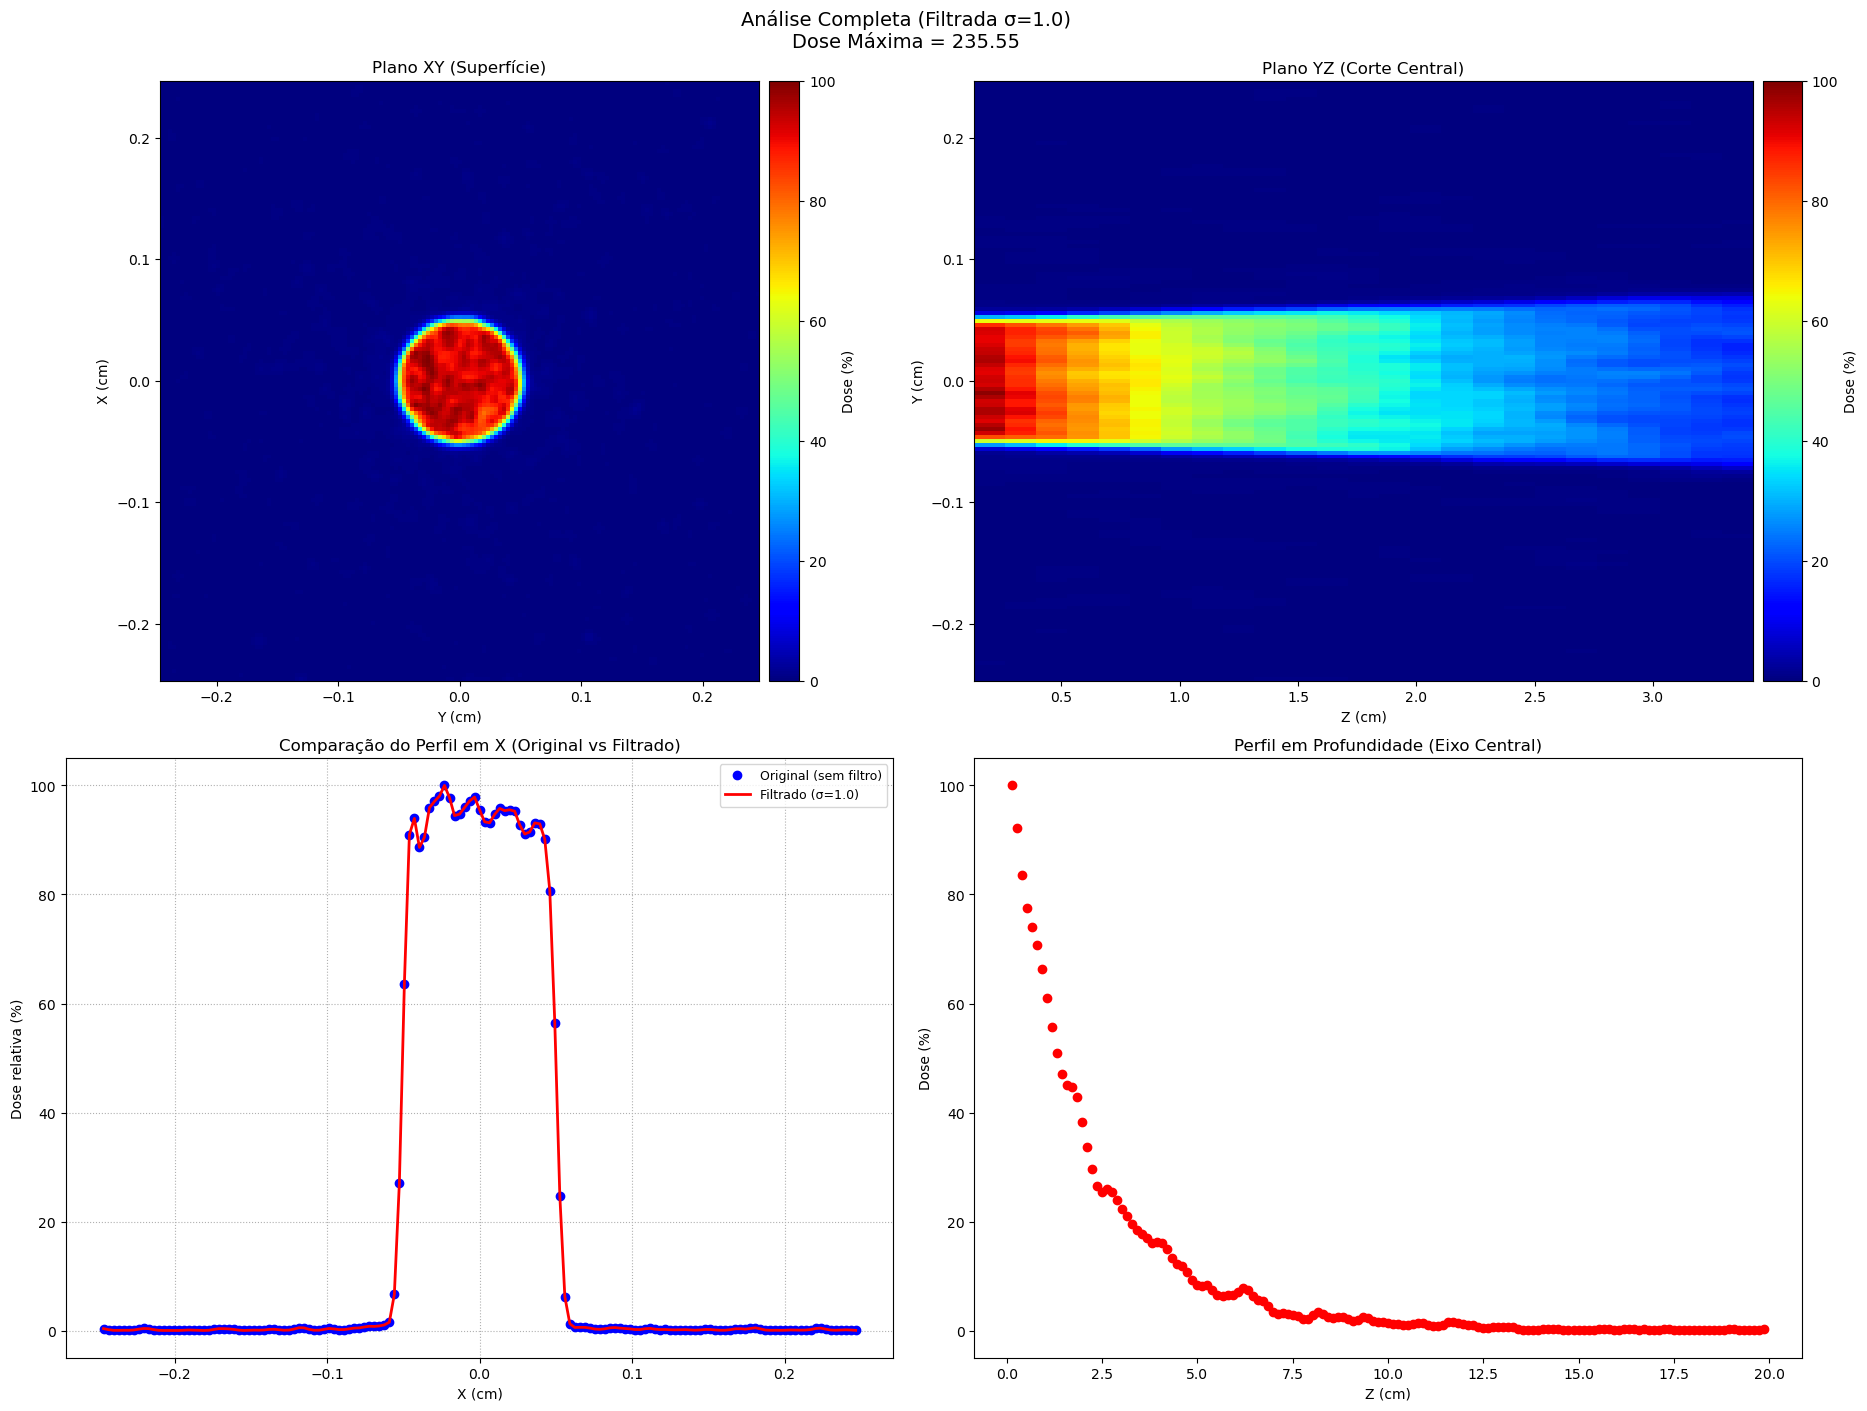

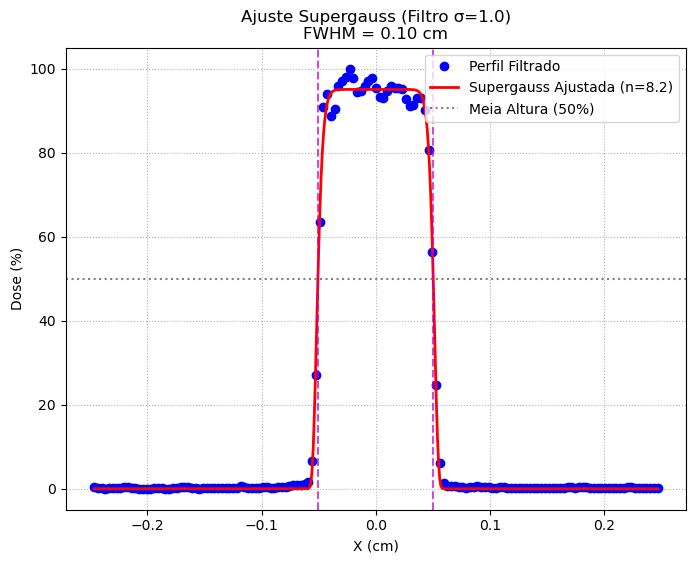


=== RESULTADOS DO AJUSTE ===
Amplitude: 95.07 %
Centro (μ): -0.000 cm
Sigma: 0.037 cm
Ordem n: 8.19
FWHM (numérico): 0.10 cm


In [16]:

# =================== PLOT CONSOLIDADO ===================
def plot_dose_consolidado(Dose, EscalaX, EscalaY, EscalaZ, MaxDose, i_max, j_max):
    fig = plt.figure(constrained_layout=True, figsize=(18, 14))
    gs = GridSpec(2, 2, figure=fig)

    fig.suptitle(f'Análise Completa (Filtrada σ={sigma_filter})\nDose Máxima = {MaxDose:.2f}', fontsize=14)

    # 1. Plano XY
    ax1 = fig.add_subplot(gs[0, 0])
    PlanoXY = 100 * Dose[:, :, 0] / MaxDose
    im1 = ax1.imshow(PlanoXY, extent=[EscalaY[0], EscalaY[-1], EscalaX[0], EscalaX[-1]],
                     origin='lower', cmap=cmap, vmin=0, vmax=100)
    ax1.set_title('Plano XY (Superfície)')
    ax1.set_xlabel('Y (cm)')
    ax1.set_ylabel('X (cm)')
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1, label='Dose (%)')

    # 2. Plano YZ
    ax2 = fig.add_subplot(gs[0, 1])
    PlanoYZ = 100 * Dose[int(i_max/2), :, :25] / MaxDose
    im2 = ax2.imshow(PlanoYZ, extent=[EscalaZ[0], EscalaZ[25], EscalaY[0], EscalaY[-1]],
                     origin='lower', aspect='auto', cmap=cmap, vmin=0, vmax=100)
    ax2.set_title('Plano YZ (Corte Central)')
    ax2.set_xlabel('Z (cm)')
    ax2.set_ylabel('Y (cm)')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im2, cax=cax2, label='Dose (%)')

    # 3. Comparação Perfil X (Original vs Filtrado)
    ax3 = fig.add_subplot(gs[1, 0])
    Perfil_original = Dose[:, int(j_max/2), 0]
    Perfil_filtrado = Dose_filt[:, int(j_max/2), 0]

# Normaliza ambos para 100%
    Perfil_original_norm = 100 * Perfil_original / np.max(Perfil_original)
    Perfil_filtrado_norm = 100 * Perfil_filtrado / np.max(Perfil_filtrado)

    ax3.plot(EscalaX, Perfil_original_norm, 'bo', linewidth=2, label='Original (sem filtro)')
    ax3.plot(EscalaX, Perfil_filtrado_norm, 'r-', linewidth=2, label=f'Filtrado (σ={sigma_filter})')
    ax3.set_title('Comparação do Perfil em X (Original vs Filtrado)')
    ax3.set_xlabel('X (cm)')
    ax3.set_ylabel('Dose relativa (%)')
    ax3.grid(True, linestyle=':')
    ax3.legend(loc='best', fontsize=9)
    # 4. PDP
    ax4 = fig.add_subplot(gs[1, 1])
    PDP = Dose[int(i_max/2), int(j_max/2), :]
    ax4.plot(EscalaZ, 100*PDP/np.max(PDP), 'ro', linewidth=2)
    ax4.set_title('Perfil em Profundidade (Eixo Central)')
    ax4.set_xlabel('Z (cm)')
    ax4.set_ylabel('Dose (%)')

    plt.show()

plot_dose_consolidado(Dose_filt, EscalaX, EscalaY, EscalaZ, max_dose_filtrada, i_max, j_max)

# =================== AJUSTE SUPERGAUSSIANO ===================
PerfilX = Dose_filt[:, int(j_max/2), 0]
Perfil_norm = 100 * PerfilX / np.max(PerfilX)

A0 = np.max(Perfil_norm)
mu0 = EscalaX[np.argmax(Perfil_norm)]
half_max = A0 / 2
left_idx, right_idx = np.where(Perfil_norm >= half_max)[0][[0, -1]]
sigma0 = (EscalaX[right_idx] - EscalaX[left_idx]) / 2.355
n0 = 2

popt, _ = curve_fit(supergauss, EscalaX, Perfil_norm,
                    p0=[A0, mu0, sigma0, n0],
                    bounds=([0, EscalaX[0], 0, 1], [150, EscalaX[-1], 1, 10]))
A_fit, mu_fit, sigma_fit, n_fit = popt

x_fit = np.linspace(EscalaX[0], EscalaX[-1], 500)
y_fit = supergauss(x_fit, *popt)

# =================== CÁLCULO NUMÉRICO DO FWHM ===================
def half_max_func(x):
    return supergauss(x, *popt) - A_fit/2

root_left = root_scalar(half_max_func, bracket=[EscalaX[0], mu_fit], method='brentq').root
root_right = root_scalar(half_max_func, bracket=[mu_fit, EscalaX[-1]], method='brentq').root
FWHM = root_right - root_left

# =================== PLOT DO AJUSTE ===================
plt.figure(figsize=(8, 6))
plt.plot(EscalaX, Perfil_norm, 'bo', label='Perfil Filtrado')
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f'Supergauss Ajustada (n={n_fit:.1f})')
plt.axhline(half_max, color='gray', linestyle=':', label='Meia Altura (50%)')
plt.axvline(root_left, color='m', linestyle='--', alpha=0.7)
plt.axvline(root_right, color='m', linestyle='--', alpha=0.7)
plt.title(f'Ajuste Supergauss (Filtro σ={sigma_filter})\nFWHM = {FWHM:.2f} cm')
plt.xlabel('X (cm)')
plt.ylabel('Dose (%)')
plt.grid(True, linestyle=':')
plt.legend()
plt.show()

print(f"\n=== RESULTADOS DO AJUSTE ===")
print(f"Amplitude: {A_fit:.2f} %")
print(f"Centro (μ): {mu_fit:.3f} cm")
print(f"Sigma: {sigma_fit:.3f} cm")
print(f"Ordem n: {n_fit:.2f}")
print(f"FWHM (numérico): {FWHM:.2f} cm")
